# Image processing pipeline on representative bone marrow sample

This notebook gives an overview of all steps of the image processing pipeline applied to one representative bone marrow sample. 

## Loading multiplex IF and IMC images

First, we read the raw 3-plex IF and 44-plex (including calibration channels) IMC images. The nomenclature of the files is essential and should be as follows:
- sample folder: staining_data_IMC_date_sample_ID_tissue_type
- IF image: staining_data_IMC_date_sample_ID_tissue_type_image_number_channel.TIF
- IMC image: staining_data_IMC_date_sample_ID_tissue_type.mcd

Large IF images were generated (roughly 9,000 x 9,000 px) to account for the offset between IF and IMC measurements. IMC images have an initial size of 700 x 700 px, but are cropped by 2 pixel to eliminate ablation artifacts on image borders yielding a final size of 696 x 696 pixels. 

In [1]:
from MapMetIP.MapMetIP.sample import MapMetIP_Sample
from pathlib import Path
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
import os

THIS_FILE = Path(os.getcwd())

base = THIS_FILE.parent.joinpath("test_data/BM")
sample_name = "20220727_20220222_16-4503_BM"

sample_folder = base.joinpath("data", sample_name)
sample = MapMetIP_Sample(sample_folder)

#select ROI for visualization
roi_vis=1 

IF = sample.mod0[roi_vis]
IMC = sample.mod1[roi_vis]

clear_output()
print("The", IF.image_stack.shape[0],"- plex IF images have a size of ",IF.image_stack.shape[1]," x " ,IF.image_stack.shape[2]," px.")
print("The", IMC.image_stack.shape[0],"- plex IMC images have a size of ",IMC.image_stack.shape[1]," x " ,IMC.image_stack.shape[2]," px.")


The 3 - plex IF images have a size of  8704  x  9728  px.
The 44 - plex IMC images have a size of  696  x  696  px.


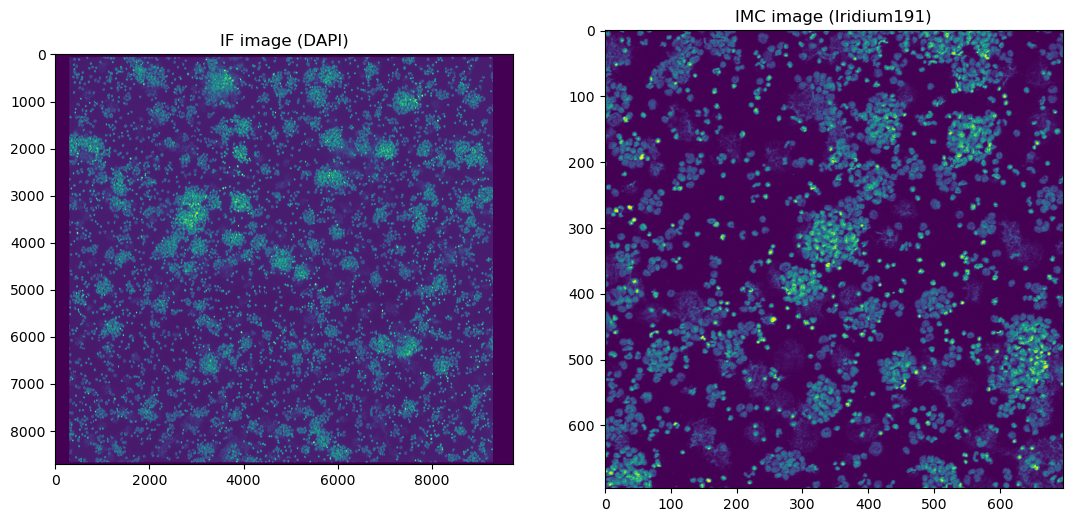

In [7]:
#select IF channel to visualize
channel_IF="IF1_DAPI"

#select IMC channel to visualize
channel_IMC="DNA1_Ir191"

#plot images
IF_nuclear_image = IF.image_stack[IF.stack_channels==channel_IF][0]

IMC_image = IMC.image_stack[IMC.stack_channels==channel_IMC][0]

fig, ax = plt.subplots(1, 2, figsize=(13, 13))
ax[0].imshow(IF_nuclear_image)
ax[1].imshow(np.clip(IMC_image, 0, np.percentile(IMC_image, 99.9))) # clipping for better visualization

ax[0].set_title('IF image (DAPI)')
ax[1].set_title('IMC image (Iridium191)')

plt.show()

## Segmentation based on nuclear IF image

For segmentation, we use our finetuned cellpose model on the high-resolution nuclear IF image. Cellpose requires the definition of an average nuclear diameter (``segmentation_diameter``) in pixels. For BM samples, which contain a high number of segmented nuclei (e.g. in neutrophils), we refine masks upon segmentation by zeroing the mask where the corresponding DAPI image falls below a defined threshold (``refine_threshold``). 

In [8]:
from MapMetIP.MapMetIP.segmentation import Segmenter
segmenter = Segmenter("CP_BM")

segmentation_diameter = 55
refine_threshold = 0.12

for roi in sample.roi_nums:
        
    IF = sample.mod0[roi]
    IMC = sample.mod1[roi]

    IF_nuclear_image = IF.image_stack[IF.stack_channels == "IF1_DAPI"]
    
    segmentation_masks, refined_segmentation_masks = segmenter.segment(
        IF_nuclear_image.squeeze(), 
        eval_kwargs={"diameter": segmentation_diameter},
        refine_threshold=refine_threshold)

KeyboardInterrupt: 

## Registration of IF and IMC images and segmentation masks

We register the IF and IMC images based on the nuclear IF (DAPI) and nuclear IMC image, the latter being the mean of four nuclear markers (H3K9Ac, H4K12Ac, Ir191 and Ir193). 

In [5]:
# calculate nuclear IMC image based on mean of four nuclear markers
sample.calculate_nuclear_image()

Registration is performed based on scale-invariant feature transformation (**DOI**: 10.1109/ICCCNT.2012.6396024).

For the estimation of an affine transformation, images are pre-processed by 
- hot-pixel removal
- CLAHE-based histogram equalization and
- clipping to the 1st and 99th percentile

We then compute a transformation matrix from the larger, high-resolution IF to the smaller, low-resolution IMC image (``h_mov2fix``) and vice versa, by inverting the determined transformation matrix (``h_fix2mov``). We use the transformation matrix ``h_mov2fix`` to align the IF to the IMC image channels. We also align the segmentation mask to the IMC images. This mask (``small_segmentation_masks``) is later used to extract intensity features from IF-IMC image channels. Morphological features are however extracted from the high-resolution IF nuclear image. To this end, we align the IMC nuclear image to the IF nuclear image (keeping the latter fixed) using the inverted tranformation matrix ``h_fix2mov``. The segmentation matrix is then cropped according to the shape of the aligned IMC nuclear image. 

In [6]:
from MapMetIP.MapMetIP.register import Registerer

registerer = Registerer("SIFT")

for roi in sample.roi_nums:
    
    IF = sample.mod0[roi]
    IMC = sample.mod1[roi]

    IF_nuclear_image = IF.image_stack[IF.stack_channels == "IF1_DAPI"]
    IMC_nuclear_image = IMC.nuclear_image
    
    #Estimate affine transformation
    registerer.register(
        mov=IF_nuclear_image.squeeze(), 
        fix=IMC_nuclear_image.squeeze(), 
        preprocessing=True)

    if roi == roi_vis:

        print("Transformation matrix for ROI ", roi_vis, "from IF to IMC: \n", registerer.h_mov2fix, "\n")
        print("Transformation matrix for ROI ", roi_vis, "from IMC to IF: \n", registerer.h_fix2mov)
    
    #Apply transformation to IF image
    IF.image_stack = registerer.warp(IF.image_stack, IMC_nuclear_image.squeeze().shape, registerer.h_mov2fix)

    #Apply transformatino to segmentation mask
    small_segmentation_masks = registerer.warp(refined_segmentation_masks, IMC_nuclear_image.squeeze().shape, registerer.h_mov2fix, interpolation=cv2.INTER_NEAREST)

    #Align IMC nuclear image to segmentation mask and crop the latter
    IMC_nuclear_image_registered = registerer.warp(IMC_nuclear_image, IF_nuclear_image.squeeze().shape, registerer.h_fix2mov)

    tmp = np.ones_like(IMC_nuclear_image)
    crop_template = registerer.warp(tmp, IF_nuclear_image.squeeze().shape, registerer.h_fix2mov)

    idxs = np.where(crop_template != 0)
    xmin, xmax = idxs[0].min(), idxs[0].max()
    ymin, ymax = idxs[1].min(), idxs[1].max()

    large_segmentation_masks = refined_segmentation_masks[xmin:xmax, ymin:ymax]

    #save segmentation masks
    sample.data[roi] = {
    "large_segmentation_masks": large_segmentation_masks,
    "small_segmentation_masks": small_segmentation_masks
}

Transformation matrix from IF to IMC: 
 [[-1.60381508e-04 -1.72141085e-01  1.09785435e+03]
 [ 1.72141085e-01 -1.60381508e-04 -5.12808899e+02]] 

Transformation matrix from IMC to IF: 
 [[-5.41233720e-03  5.80918340e+00  2.98494290e+03]
 [-5.80918340e+00 -5.41233720e-03  6.37486178e+03]]


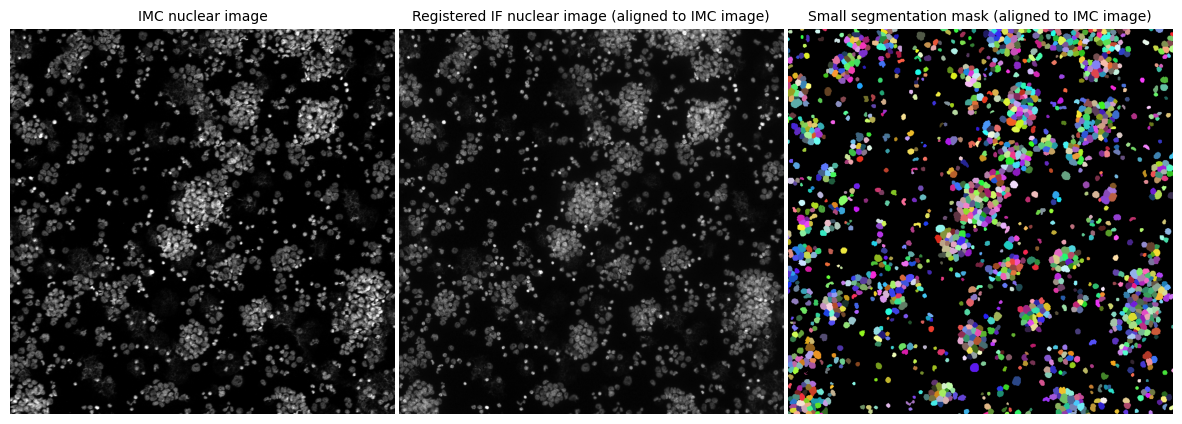

In [8]:
import cv2

#registered nuclear IF image
IF = sample.mod0[roi_vis]
IMC = sample.mod1[roi_vis]

channel_IF="IF1_DAPI"
IF_nuclear_image_registered = IF.image_stack[IF.stack_channels==channel_IF]

IMC_nuclear_image = IMC.nuclear_image

#registered segmentation mask
small_mask = sample.data[roi_vis].small_segmentation_masks

gridPlot([np.clip(IMC_nuclear_image, 0, np.percentile(IMC_nuclear_image, 99.9)), #clipping for better visualization
          IF_nuclear_image_registered, rand_col_seg(small_segmentation_masks)], 
          titles=["IMC nuclear image", "Registered IF nuclear image (aligned to IMC image)", "Small segmentation mask (aligned to IMC image)"], 
          grid_size=(1,3), plot_size=(15,6), hspace=0.0001, vspace=0.01)

## Spillover compensation, Background correction and Normalization

Before we extract intensity features from the IF and IMC image channels, we perform spillover and background correction. 

### Spillover compensation

We generate the spillover matrix and perform the spillover correction by calling an R-based docker container as a subprocess. The ``spillover_folder`` contains spillover measurements for each channel in txt.files. The ``out_folder`` is reserved for saving the spillover_matrix and temporary files. 

In [11]:
from MapMetIP.MapMetIP.spillover import spillover_correction
import copy

sample_old = copy.deepcopy(sample)

#spillover compensation
spillover_folder = THIS_FILE.parent.joinpath("test_data/SPILLOVER")
out_folder = THIS_FILE.parent.joinpath("test_data/SPILLOVER/out")

sample = spillover_correction(sample, spillover_folder, out_folder)

100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


[1] "Generating Spillover Matrix ..."
Spotted channels:  Y89, In115, La139, Nd142, Nd143, Nd144, Nd145, Nd146, Sm147, Nd148, Sm149, Nd150, Eu151, Sm152, Eu153, Sm154, Gd155, Gd156, Gd158, Tb159, Gd160, Dy161, Dy162, Dy163, Dy164, Ho165, Er166, Er167, Er168, Tm169, Er170, Yb171, Yb172, Yb173, Yb174, Lu175, Yb176, Ir191, Ir193, Pt196, Bi209
Acquired channels:  Y89, In115, Xe131, Xe134, Ba136, La139, Nd142, Nd143, Nd144, Nd145, Nd146, Sm147, Nd148, Sm149, Nd150, Eu151, Sm152, Eu153, Sm154, Gd155, Gd156, Gd158, Tb159, Gd160, Dy161, Dy162, Dy163, Dy164, Ho165, Er166, Er167, Er168, Tm169, Er170, Yb171, Yb172, Yb173, Yb174, Lu175, Yb176, Ir191, Ir193, Pt196, Bi209
Channels spotted but not acquired:  
Channels acquired but not spotted:  Xe131, Xe134, Ba136

Debarcoding data...
 o ordering
 o classifying events
Normalizing...
Computing deltas...
Compensation is likely to be inaccurate.
Spill values for the following interactions
have not been estimated:
Xe131Di -> Xe134Di, Ba136Di, Sm147Di
Xe134Di -> Xe131Di, Ba136Di, Nd150Di
Ba136Di -> Xe134Di, Sm152Di


[1] "Compensating for 20220727_20220222_16-4503_BM_1.tiff"


Although hardly visible the difference between these two images is  177685.5 .


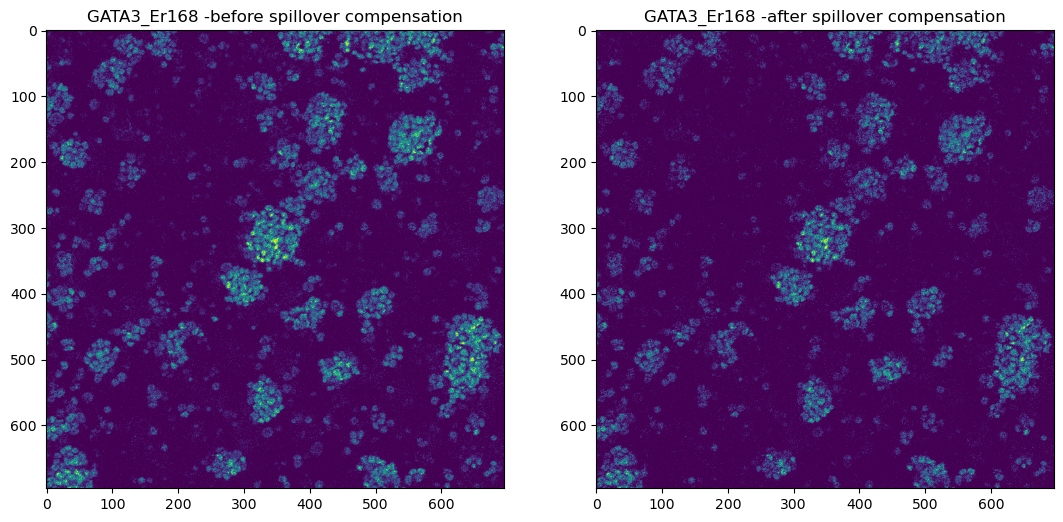

In [12]:
#channel to visualize spillover
channel_IMC='GATA3_Er168'

#before
IMC_old = sample_old.mod1[roi_vis]
image_before = IMC_old.image_stack[MC_old.stack_channels==channel_IMC]

#after
IMC = sample.mod1[roi_vis]
image_after = IMC.image_stack[IMC.stack_channels==channel_IMC]

#plot images - clipping for visualization
fig, ax = plt.subplots(1, 2, figsize=(13, 13))
ax[0].imshow(np.clip(image_before, 0, np.percentile(image_before, 99.9)))
ax[1].imshow(np.clip(image_after, 0, np.percentile(image_before, 99.9)))

ax[0].set_title(channel_IMC + ' -before spillover compensation')
ax[1].set_title(channel_IMC + ' -after spillover compensation')

print("Although hardly visible the difference between these two images is ", (image_before-image_after).sum(), ".")

After spillover compensation of the IMC images, we can stack the registered IF with the spillover-compensated IMC images.

In [13]:
#Concatenate IMC and IF images into multi-channel image
all_pixelvalues = []

all_stack = np.concatenate((IMC.image_stack, IF.image_stack), axis=0)
all_channels = np.concatenate((IMC.stack_channels, IF.stack_channels))

all_pixelvalues.append(np.reshape(all_stack, (all_stack.shape[0], -1)))

sample.data[roi]["all_stack"] = all_stack
sample.data[roi]["all_channels"] = all_channels
        
setattr(sample, "all_channels", all_channels)
setattr(sample, "all_pixelvalues", np.concatenate(all_pixelvalues, axis=1))

### Hot pixel removal

We remove hot pixels using DIMR (differential intensity map-based restoration) function implemented in IMC-Denoise by [Lu et al.](https://www.nature.com/articles/s41467-023-37123-6#code-availability). 

In [14]:
from IMC_Denoise.IMC_Denoise.IMC_Denoise_main.DIMR import DIMR

sample_old = copy.deepcopy(sample)

data = sample.data[roi]
    
hrm_stack = []
for image in data["all_stack"]:
    hrm_stack.append(DIMR(n_neighbours=4, n_iter=3, window_size=3).perform_DIMR(image))

sample.data[roi]["all_stack"] = np.array(hrm_stack)

Text(0.5, 1.0, 'DNA1_Ir193 - after DIMR hotpixel removal - zoom')

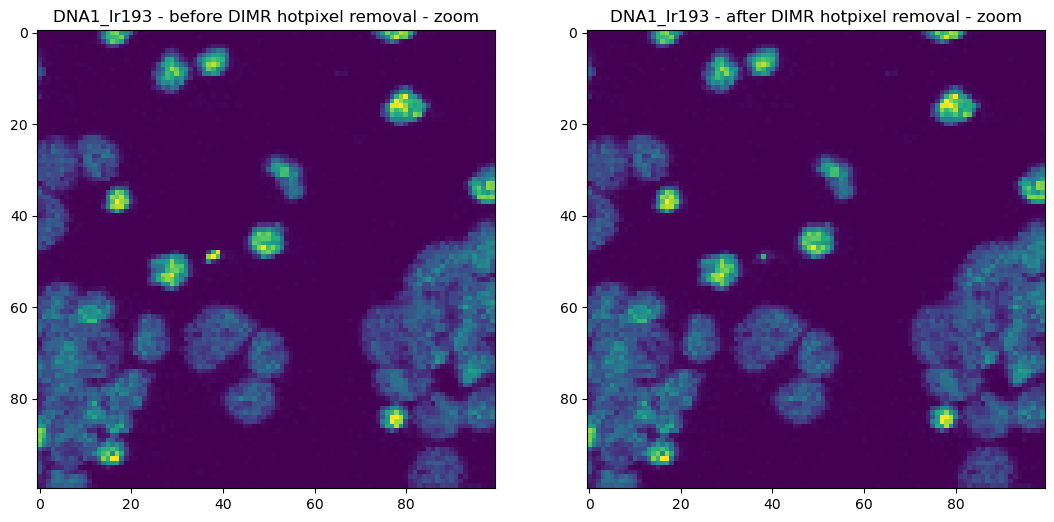

In [15]:
#channel to visualize spillover
channel='DNA1_Ir193'

#before
stack_old = sample_old.data[roi]["all_stack"]
channel_idx = np.where(sample_old.all_channels==channel)[0][0]
image_before = stack_old[channel_idx]

#after
stack = sample.data[roi]["all_stack"]
channel_idx = np.where(sample.all_channels==channel)[0][0]
image_after = stack[channel_idx]

#plot images 
fig, ax = plt.subplots(1, 2, figsize=(13, 13))
ax[0].imshow(np.clip(image_before[350:450, 400:500], 0, np.percentile(image_before, 99.9)))
ax[1].imshow(np.clip(image_after[350:450, 400:500], 0, np.percentile(image_after, 99.9)))

ax[0].set_title(channel + ' - before DIMR hotpixel removal - zoom')
ax[1].set_title(channel + ' - after DIMR hotpixel removal - zoom')

### Background correction and normalization
Background correction is performed with the following steps:
- Clipping images to the 99.5th percentile (99th for HLA-ABC due to high number of staining artifacts) for outlier removal
- Background removal using classifier trained in Ilastik (1 classifier/marker)
- Min-max normalization between 0 and 1

In [16]:
from MapMetIP.MapMetIP.background_correction import BackgroundCorrecter
from MapMetIP.MapMetIP.normalize import percentile_clip, minmax_sample

#Clip for outlier removal
sample = percentile_clip(sample, clip_values)
sample_old = copy.deepcopy(sample)

#Background correction
backgroundcorrection_folder = THIS_FILE.parent.joinpath("test_data/BM/BC_model")

bc = BackgroundCorrecter(backgroundcorrection_folder)
data = sample.data[roi]
corrected, masks, new_channels = bc.correct(data["clipped_stack"], data["all_stack"], channels=data["all_channels"], keep_channels=sample.KEEP_CHANNELS)
sample.data[roi]["data_corrected"] = corrected
sample.data[roi]["data_channels"] = new_channels

sample = minmax_sample(sample, min_value, max_value)

Text(0.5, 1.0, 'CD44_In115 - after background correction')

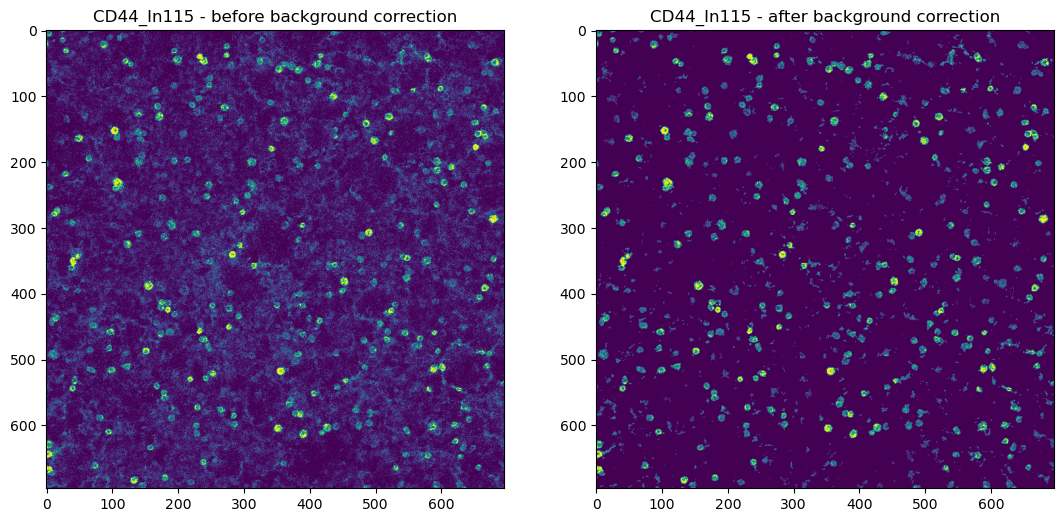

In [17]:
#channel to visualize background correction
channel='CD44_In115'

#before
stack_old = sample_old.data[roi]["clipped_stack"]
channel_idx = np.where(sample_old.all_channels==channel)[0][0]
image_before = stack_old[channel_idx]

#after
stack = sample.data[roi]["data_minmax"]
channel_idx = np.where(sample.all_channels==channel)[0][0]
image_after = stack[channel_idx]

#plot images 
fig, ax = plt.subplots(1, 2, figsize=(13, 13))
ax[0].imshow(image_before)
ax[1].imshow(image_after)

ax[0].set_title(channel + ' - before background correction')
ax[1].set_title(channel + ' - after background correction')

## Extraction of intensity and morphological features

1. We export intensity features from the corrected IMC-IF image stacks using the registered, small segmentation masks as well as a dilated (by 1px) version of the latter.
2. Then, we export morphological features based on the cropped, large segmentation masks. 
3. Finally, we export cell neighbors based on ``CENTROID_DISTANCE``.

In [18]:
from MapMetIP.MapMetIP.feature_extraction import FeatureExtractor, extract_sample_features, MORPH_MEASURES
from MapMetIP.MapMetIP.neighbors import extract_neighbors

featureextractor = FeatureExtractor(additional_morphology_functions=MORPH_MEASURES) 

sample = extract_sample_features(sample, featureextractor)
sample = extract_neighbors(sample, dmax=150)

100%|██████████| 1/1 [00:00<00:00,  8.00it/s]


## Save images, masks and single-cell data

Finally, we save multi-channel IMC-IF images, registered segmentation masks and extracted single-cell data. 

In [19]:
from MapMetIP.MapMetIP.sample import save_sample

save_dir = THIS_FILE.parent.joinpath("test_data/BM/results")

save_sample(sample, save_dir)

1 dict_keys(['large_segmentation_masks', 'small_segmentation_masks', 'all_stack', 'all_channels', 'clipped_stack', 'data_corrected', 'data_channels', 'data_minmax', 'intensiy_features_0', 'intensiy_features_1', 'morphological_features', 'neighbors'])


In [20]:
import pandas as pd 

df_old = pd.read_csv(os.path.join(save_dir, "intensities-0px/20220727_20220222_16-4503_BM_001.csv"))

df_new = pd.read_csv("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/PIPELINE/NEWEST_RESULTS/intensities-0px-ref/20220727_20220222_16-4503_BM_001.csv")

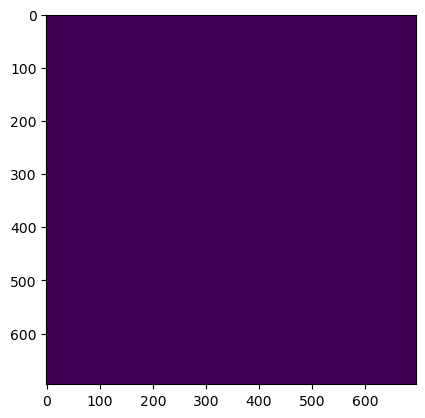

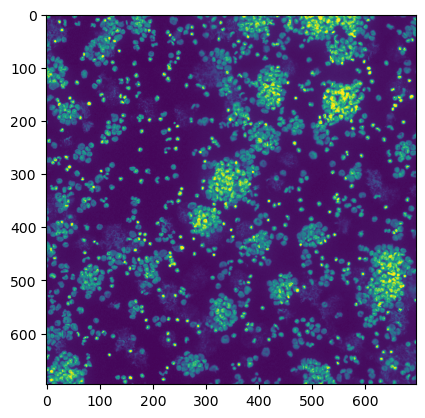

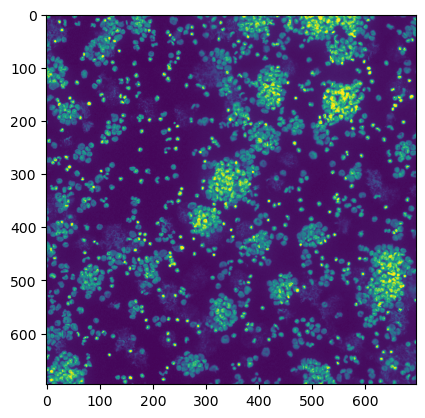

15.264151
0.018518519


In [27]:
import tifffile as tiff
img_new = tiff.imread(os.path.join(save_dir, "img/20220727_20220222_16-4503_BM_001.tif"))[41]
img_old = tiff.imread("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/PIPELINE/NEWEST_RESULTS/img/20220727_20220222_16-4503_BM_001.tif")[41]


plt.imshow(img_old - img_new, vmin=0, vmax=1); plt.show()

plt.imshow(img_new); plt.show()
plt.imshow(img_old); plt.show()

print(img_new.min())
print(img_old.min())

In [27]:
df_new.shape

(1623, 89)

In [21]:
df_old.sum() - df_new.sum()

Object                         0.000000
MPO_Y89_mean                2998.017907
CD44_In115_mean             3212.976111
Fibronectin_La139_mean        85.618957
CD11b_Nd142_mean             707.105341
                              ...      
Vimentin_Pt196_mean-80     14886.585551
CD15_Bi209_mean-80         46872.963559
IF1_DAPI_mean-80          202115.624665
IF2_GD2_mean-80           170227.724117
IF3_CD56_mean-80          163512.254119
Length: 89, dtype: float64